In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import json
import numpy as np
import math
from nltk import word_tokenize
import torchtext
from transformers import BertTokenizer, BertModel, BertConfig
import matplotlib.pyplot as plt

batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


141
34
10.12


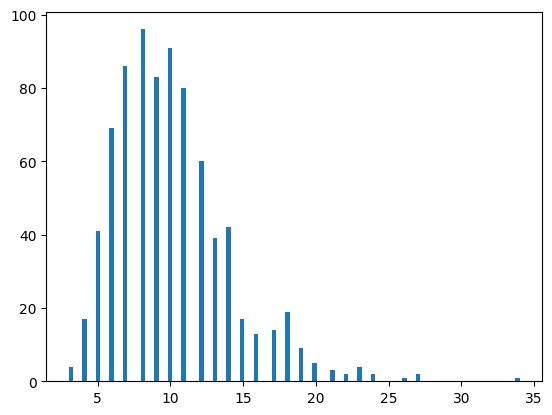

In [2]:
# find the largest sentence length
sent_max_len = 0
max_sent_count = 0
tot_sent_count = 0
num_docs = 0
sent_counts = []
with open('./processed_data/GCDC/Clinton_train.jsonl', 'r') as f:
    for line in f:
        data = json.loads(line)
        num_docs += 1
        sent_count = len(data['sentences'])
        sent_counts.append(sent_count)
        max_sent_count = max(max_sent_count, sent_count)
        tot_sent_count += sent_count
        for sentence in data['sentences']:
            sent_max_len = max(sent_max_len, len(sentence))
print(sent_max_len)
print(max_sent_count)
print(tot_sent_count/num_docs)

# plot the sentence length distribution
plt.hist(sent_counts, bins=100)
plt.show()

In [3]:
sent_max_len = 128
max_sent_in_doc = 18

pad_sent = ['[PAD]'] * sent_max_len
pad_sent = ' '.join(pad_sent)
# print(pad_sent)

# tokenize the data, while adding [SEP] token between sentences
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
sentences = []
labels = []
# have exactly max_sent_in_doc sentences in each document, pad with [PAD] token if not enough
with open('./processed_data/GCDC/Clinton_train.jsonl', 'r') as f:
    for line in f:
        data = json.loads(line)
        sent_count = 0
        for sentence in data['sentences']:
            if sent_count >= max_sent_in_doc:
                break
            # join the tokens in the sentence
            sentence = sentence[:sent_max_len-2]
            # pad to max_sent_len with [PAD] token
            sentence = sentence + ['[SEP]'] + ['[PAD]'] * (sent_max_len-len(sentence)-1)            
            sentence = ' '.join(sentence)
            sentences.append(sentence)
            labels.append(data['label'])
            sent_count += 1
        # pad with [PAD] token if not enough sentences
        if len(data['sentences']) < max_sent_in_doc:
            for i in range(max_sent_in_doc-len(data['sentences'])):
                sentences.append(pad_sent)
                labels.append(data['label'])


print(len(sentences))
print(len(labels))

# merge the sentences into documents
docs = []
doc_labels = []
for i in range(0, len(sentences), max_sent_in_doc):
    docs.append(sentences[i:i+max_sent_in_doc])
    docs[-1] = ' '.join(docs[-1])
    doc_labels.append(labels[i]-1)

print(len(docs))
print(len(doc_labels))

for i in range(5):
    print(docs[i])
    print(doc_labels[i])
    print()

#  do the same for the test data
sentences_test = []
labels_test = []
with open('./processed_data/GCDC/Clinton_test.jsonl', 'r') as f:
    for line in f:
        data = json.loads(line)
        sent_count = 0
        for sentence in data['sentences']:
            if sent_count >= max_sent_in_doc:
                break
            # join the tokens in the sentence
            sentence = sentence[:sent_max_len-2]
            # pad to max_sent_len with [PAD] token
            sentence = sentence + ['[SEP]'] + ['[PAD]'] * (sent_max_len-len(sentence)-1)            
            sentence = ' '.join(sentence)
            sentences_test.append(sentence)
            labels_test.append(data['label'])
            sent_count += 1
        # pad with [PAD] token if not enough sentences
        if len(data['sentences']) < max_sent_in_doc:
            for i in range(max_sent_in_doc-len(data['sentences'])):
                sentences_test.append(pad_sent)
                labels_test.append(data['label'])

print(len(sentences_test))
print(len(labels_test))

# merge the sentences into documents
docs_test = []
doc_labels_test = []
for i in range(0, len(sentences_test), max_sent_in_doc):
    docs_test.append(sentences_test[i:i+max_sent_in_doc])
    docs_test[-1] = ' '.join(docs_test[-1])
    doc_labels_test.append(labels_test[i]-1)

print(len(docs_test))
print(len(doc_labels_test))

for i in range(5):
    print(docs_test[i])
    print(doc_labels_test[i])
    print()


14400
14400
800
800
Two options The US views the Transitional National Council as the sole / only legitimate interlocutor of the Libyan people during this interim period , as Libyans come together to plan their own future and a permanent , inclusive constitutional system that protects the rights of all Libyans . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] This is in contrast to the Qadhafi regime , which has lost all legitimacy to rule . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [4]:
# sent_max_len = 128
# max_sent_in_doc = 18

# # tokenize the data, while adding [SEP] token between sentences
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# sentences = []
# labels = []

# with open('./processed_data/GCDC/Clinton_train.jsonl', 'r') as f:
#     for line in f:
#         data = json.loads(line)
#         for sentence in data['sentences']:
#             # join the tokens in the sentence
#             sentence = sentence[:sent_max_len-2]
#             sentence = ' '.join(sentence)
#             sentences.append(sentence)
#             labels.append(data['label'])
#             sent_count += 1
#         sentences.append('[SEP]')
#         labels.append(data['label'])


# print(len(sentences))
# for i in range(10):
#     print(sentences[i])
#     print(labels[i])
#     print()
# sentences = tokenizer(sentences, padding=True, truncation=True, max_length=sent_max_len, return_tensors='pt')
# labels = torch.tensor(labels)
# print(sentences['input_ids'].shape)
# print(labels.shape)
# print(sentences['input_ids'][0])
# print(sentences['attention_mask'][0])
# print(tokenizer.decode(sentences['input_ids'][0]))
# print(sentences['input_ids'][5])
# print(sentences['attention_mask'][5])
# print(tokenizer.decode(sentences['input_ids'][5]))


In [5]:
# tokenize the data
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
docs_encoding_tensor = tokenizer(docs, padding=True, truncation=True, max_length=sent_max_len*max_sent_in_doc, return_tensors='pt')
doc_labels_tensor = torch.tensor(doc_labels)

# change the attention mask so that all 0 values in the input_ids are also 0 in the attention mask
docs_encoding_tensor['attention_mask'] = docs_encoding_tensor['attention_mask'] * (docs_encoding_tensor['input_ids'] != 0)
print(docs_encoding_tensor['attention_mask'].shape)

print(docs_encoding_tensor['input_ids'].shape)
print(doc_labels_tensor.shape)
print(docs_encoding_tensor['input_ids'][0])
print(docs_encoding_tensor['attention_mask'][0])
# print(tokenizer.decode(docs['input_ids'][0]))

# tokenize the test data
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
docs_encoding_tensor_test = tokenizer(docs_test, padding=True, truncation=True, max_length=sent_max_len*max_sent_in_doc, return_tensors='pt')
doc_labels_tensor_test = torch.tensor(doc_labels_test)

# change the attention mask so that all 0 values in the input_ids are also 0 in the attention mask
docs_encoding_tensor_test['attention_mask'] = docs_encoding_tensor_test['attention_mask'] * (docs_encoding_tensor_test['input_ids'] != 0)
print(docs_encoding_tensor_test['attention_mask'].shape)

print(docs_encoding_tensor_test['input_ids'].shape)
print(doc_labels_tensor_test.shape)
print(docs_encoding_tensor_test['input_ids'][0])
print(docs_encoding_tensor_test['attention_mask'][0])
print(tokenizer.decode(docs_encoding_tensor_test['input_ids'][0]))

torch.Size([800, 2304])
torch.Size([800, 2304])
torch.Size([800])
tensor([ 101, 2048, 7047,  ...,    0,    0,  102])
tensor([1, 1, 1,  ..., 0, 0, 1])
torch.Size([200, 2304])
torch.Size([200, 2304])
torch.Size([200])
tensor([  101, 10602,  3187,  ...,     0,     0,   102])
tensor([1, 1, 1,  ..., 0, 0, 1])
[CLS] madame secretary : thank you for reaching out to secretary solis and convincing her to join the verification commission. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [6]:
# create the dataset
dataset = TensorDataset(docs_encoding_tensor['input_ids'], docs_encoding_tensor['attention_mask'], doc_labels_tensor)
dataset_test = TensorDataset(docs_encoding_tensor_test['input_ids'], docs_encoding_tensor_test['attention_mask'], doc_labels_tensor_test)

print(len(dataset))
print(len(dataset_test))
print(len(dataset[0][0]))

print(dataset[0])

# create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

800
200
2304
(tensor([ 101, 2048, 7047,  ...,    0,    0,  102]), tensor([1, 1, 1,  ..., 0, 0, 1]), tensor(2))


In [7]:
'''
The hierarchical model is a two-level model. The first level
is a sentece encoder, and the second level is a document encoder.
The sentence encoder takes individual sentences (separated by
SEP token) as input. The outputs from each position of the last layer
of the sentence encoder are pooled (separately for each sentence) using
pooling strategies. The pooled outputs are then fed into the document
encoder. The document encoder takes the pooled outputs from the sentence
encoder as input. Each sentence in the document is encoded by the 
sentence encoder and passed as input to the document encoder. Finally,
the CLS token's transformed representation from the document encoder is 
fed to a dense layer with ReLU activation which is then connected to a 
task-specific output layer.
'''

"\nThe hierarchical model is a two-level model. The first level\nis a sentece encoder, and the second level is a document encoder.\nThe sentence encoder takes individual sentences (separated by\nSEP token) as input. The outputs from each position of the last layer\nof the sentence encoder are pooled (separately for each sentence) using\npooling strategies. The pooled outputs are then fed into the document\nencoder. The document encoder takes the pooled outputs from the sentence\nencoder as input. Each sentence in the document is encoded by the \nsentence encoder and passed as input to the document encoder. Finally,\nthe CLS token's transformed representation from the document encoder is \nfed to a dense layer with ReLU activation which is then connected to a \ntask-specific output layer.\n"

In [8]:
# define the sentence encoder
class SentenceEncoder(nn.Module):
    def __init__(self, pooling_strategy):
        super(SentenceEncoder, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.pooling_strategy = pooling_strategy

    def forward(self, input_ids, attention_mask):
        # input_ids: (batch_size, sent_max_len*max_sent_in_doc)
        # attention_mask: (batch_size, sent_max_len*max_sent_in_doc)

        # change the shape of the input_ids and attention_mask
        # input_ids: (batch_size, max_sent_in_doc, sent_max_len)
        # attention_mask: (batch_size, max_sent_in_doc, sent_max_len)
        # use slice to get the input_ids and attention_mask for each sentence
        input_ids = input_ids.view(-1, max_sent_in_doc, sent_max_len)
        attention_mask = attention_mask.view(-1, max_sent_in_doc, sent_max_len)
        # input_ids: (batch_size*max_sent_in_doc, sent_max_len)
        # attention_mask: (batch_size*max_sent_in_doc, sent_max_len)
        input_ids = input_ids.view(-1, sent_max_len)
        attention_mask = attention_mask.view(-1, sent_max_len)

        # get the outputs from the BERT model
        # outputs: (batch_size*max_sent_in_doc, sent_max_len, hidden_size)
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        # do the pooling
        # outputs: (batch_size*max_sent_in_doc, hidden_size)
        if self.pooling_strategy == 'mean':
            outputs = torch.mean(outputs[0], dim=1)
        elif self.pooling_strategy == 'max':
            outputs = torch.max(outputs[0], dim=1)[0]
        elif self.pooling_strategy == 'cls':
            outputs = outputs[0][:, 0, :]
        else:
            raise Exception('Pooling strategy not supported!')
        # change the shape of the outputs
        # outputs: (batch_size, max_sent_in_doc, hidden_size)
        outputs = outputs.view(-1, max_sent_in_doc, outputs.shape[1])
        # we are returning the sentence encodings for each sentence in all the documents
        return outputs


# define the document encoder
class DocumentEncoder(nn.Module):
    def __init__(self):
        super(DocumentEncoder, self).__init__()
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=4, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=2)
        # self.linear = nn.Linear(max_sent_in_doc*768, 1)

    def forward(self, input_ids):
        # input_ids: (batch_size, 512)
        # doc_attention_mask: (batch_size, 512)

        # get the outputs from the transformer encoder
        # outputs: (batch_size, 512, 512)
        outputs = self.transformer_encoder(input_ids)
        # print(outputs.shape)
        # outputs: (batch_size, 512)
        # outputs = outputs[:, 0]
        return outputs


# # define the document encoder
# class DocumentEncoder(nn.Module):
#     def __init__(self):
#         super(DocumentEncoder, self).__init__()
#         self.bert_model = BertModel.from_pretrained('bert-base-uncased')

#     def forward(self, input_ids):
#         # input_ids: (batch_size, max_sent_in_doc * hidden_size)
#         # attention_mask: (batch_size, max_sent_in_doc * hidden_size)

#         # get the outputs from the BERT model
#         # outputs: (batch_size, max_sent_in_doc * hidden_size)
#         outputs = self.bert_model(input_ids=input_ids)
#         # outputs: (batch_size, hidden_size)
#         outputs = outputs[0][:, 0, :]
#         return outputs
    
# define the hierarchical model
class HierarchicalModel(nn.Module):
    def __init__(self, pooling_strategy, num_classes):
        super(HierarchicalModel, self).__init__()
        self.sentence_encoder = SentenceEncoder(pooling_strategy)
        self.intermediate = nn.Linear(max_sent_in_doc*768, 512)
        self.document_encoder = DocumentEncoder()
        self.dense = nn.Linear(512, 512)
        self.relu = nn.ReLU()
        self.output = nn.Linear(512, num_classes)

    def forward(self, input_ids, attention_mask):
        # input_ids: (batch_size, sent_max_len * max_sent_in_doc)
        # attention_mask: (batch_size, sent_max_len * max_sent_in_doc)
        
        # encode each sentence
        # output: (batch_size, max_sent_in_doc, hidden_size)
        output = self.sentence_encoder(input_ids, attention_mask)
        # print(output.shape)

        # doc_attention_mask: (batch_size, max_sent_in_doc * hidden_size)
        # use it to mask the sentences that are completely padded

        # now, we must pass the sentence encodings of each sentence in a document to the document encoder
        # we will use the doc_attention_mask to mask the sentences that are completely padded
        # change the shape of the output
        # output: (batch_size, max_sent_in_doc * hidden_size)
        output = output.view(-1, max_sent_in_doc * output.shape[2])
        # print(output.shape)
        # send the output to the intermediate layer
        # output: (batch_size, 512)
        output = self.intermediate(output)
        # print(output.shape)

        # send the output to the document encoder
        # output: (batch_size, hidden_size)
        output = self.document_encoder(output)
        # print(output.shape)
        # transform the CLS token's representation
        # output: (batch_size, hidden_size)
        output = self.dense(output)
        output = self.relu(output)
        # print(output.shape)
        # output: (batch_size, num_classes)
        output = self.output(output)
        # print(output.shape)
        return output

In [9]:
# get the doc_attention_mask
hidden_size = 768
def get_doc_attention_mask(input_ids):
    
    doc_attention_mask = torch.ones(input_ids.shape[0], max_sent_in_doc, hidden_size)
    # print(doc_attention_mask.shape)
    # check if the first token is a padding token
    # if it is a padding token, then the sentence is completely padded
    # then, we will mask all the tokens in that sentence
    # if it is not a padding token, then the sentence is not completely padded
    # then, we will not mask any token in that sentence
    # we will do this for all the sentences in all the documents
    for i in range(input_ids.shape[0]):
        for j in range(max_sent_in_doc):
            if input_ids[i][j*sent_max_len] == 0:
                doc_attention_mask[i][j] = torch.zeros(hidden_size)
    # print(doc_attention_mask.shape)
    # doc_attention_mask: (batch_size, max_sent_in_doc * hidden_size)
    doc_attention_mask = doc_attention_mask.view(-1, max_sent_in_doc * hidden_size)
    # print(doc_attention_mask.shape)
    return doc_attention_mask


In [10]:
# hyperparameters
learning_rate = 1e-5
num_epochs = 10
# batch_size = 16
pooling_strategy = 'mean'
num_classes = 3

# instantiate the model
model = HierarchicalModel(pooling_strategy, num_classes)
model = model.to(device)

# define the loss function
loss_function = nn.CrossEntropyLoss()

# define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_

In [11]:
# train the model
def train(model, train_loader, loss_function, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (input_ids, attention_mask, labels) in enumerate(train_loader):
        # send the input ids, attention mask and labels to the GPU
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        # get the doc_attention_mask
        # doc_attention_mask = get_doc_attention_mask(input_ids)
        # doc_attention_mask = doc_attention_mask.to(device)
        # zero out the gradients
        optimizer.zero_grad()
        # get the predictions
        predictions = model(input_ids, attention_mask)
        # calculate the loss
        loss = loss_function(predictions, labels)
        # backpropagate
        loss.backward()
        # update the parameters
        optimizer.step()
        # update the train loss
        train_loss += loss.item()
    return train_loss / len(train_loader)


# evaluate the model
def evaluate(model, test_loader, loss_function):
    model.eval()
    test_loss = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (input_ids, attention_mask, labels) in enumerate(test_loader):
            # send the input ids, attention mask and labels to the GPU
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            # get the doc_attention_mask
            # doc_attention_mask = get_doc_attention_mask(input_ids)
            # doc_attention_mask = doc_attention_mask.to(device)
            # get the predictions
            predictions = model(input_ids, attention_mask)
            # calculate the loss
            loss = loss_function(predictions, labels)
            # update the test loss
            test_loss += loss.item()
            # get the predicted labels
            predicted_labels = torch.argmax(predictions, dim=1)
            # update the total and correct predictions
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
    return test_loss / len(test_loader), correct / total

    

In [12]:
# train the model
for epoch in range(num_epochs):
    train_loss = train(model, dataloader, loss_function, optimizer)
    test_loss, test_accuracy = evaluate(model, dataloader_test, loss_function)
    print('Epoch: {} \tTraining Loss: {:.6f} \tTesting Loss: {:.6f} \tTesting Accuracy: {:.6f}'.format(epoch+1, train_loss, test_loss, test_accuracy))

# save the model
torch.save(model.state_dict(), 'hierarchical_model.pt')

OutOfMemoryError: CUDA out of memory. Tried to allocate 28.00 MiB (GPU 0; 5.80 GiB total capacity; 4.75 GiB already allocated; 17.44 MiB free; 4.84 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF